* Préparation des données
  1.   Charger les données.
  2.   Prétraiter les images : redimensionner et normaliser les pixels ([0,1] ou [-1,1]).

* Conception de votre propre CNN
  1.   Réaliser une architecture minimale : quelques couches de convolution (Conv2D, BatchNorm, ReLU, MaxPool), une ou plusieurs couches entièrement connectées (Dense/FC) pour la partie feature extraction et la classification.
  2.   Choisirles métriques appropriées à la classification multi-label. Faut-il privilégier l’accuracy, la F1-score, l’AP (Average Precision) par classe ou encore l’AUC ROC ?
  3. Diagnostiquer le sous-apprentissage/sur-apprentissage en traçant les courbes d’apprentissage.
  4. Tester le model sur les données test, afficher la matrice de confusion et interpréter les résultats.

* Expérimentations avec des architectures CNN avancées
  1. Choisir deux architectures parmi celles vues en cours : VGG, ResNet, Inception, EfficientNet, DenseNet, etc.
  2. Expérimentation 1 : Transfert d’apprentissage (Feature Extractor) en utilisant un modèle pré-entraîné, ne conserver que l’extracteur de caractéristiques et ajouter une nouvelle tête de classification.
  3. Expérimentation 2 : Fine-tuning partiel en dégelant certaines couches et les réentraînant pour adapter le modèle au dataset.
  4. Expérimentation 3 : Entraînement « from scratch » sans poids pré-entraînés.

* Comparaison des résultats et choix du modèle final
  1. Comparer les performances des différents modèles expérimentés à l’aide de la matrice de confusion et des métriques sélectionnées, adaptées à la classification multi-label.
  2. Justifier le choix du modèle retenu.

* Analyse des résultats
  1. Afficher quelques images de test avec les prédictions et les scores de confiance correspondants.
  2. Utiliser des techniques d’interprétation, comme LIME, pour mieux comprendre les décisions du modèle.
  3. Examiner des erreurs de prédiction et essayer d’identifier des explications.
  4. Interpréter les résultats et proposer des pistes d’amélioration.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Préparation des données
  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, average_precision_score

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

Charger les données.

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/train_split.csv')
test_df = pd.read_csv('/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/test_split.csv')
val_df = pd.read_csv('/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/val_split.csv')

Nous allons transformer les labels en tenseurs

In [5]:
def convert_to_list(labels):
    return [label.split(' ') for label in labels]

train_df['Labels'] = convert_to_list(train_df['Labels'])
val_df['Labels'] = convert_to_list(val_df['Labels'])
test_df['Labels'] = convert_to_list(test_df['Labels'])

In [6]:
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_df['Labels'])
val_labels   = mlb.transform(val_df['Labels'])
test_labels  = mlb.transform(test_df['Labels'])

In [7]:
# get number of classes
classes_nbr = (len(mlb.__dict__['classes_']))
classes_nbr

16

In [8]:
mlb.__dict__['classes_']

array(['10', '11', '13', '15', '16', '17', '18', '19', '2', '3', '4', '5',
       '6', '7', '8', '9'], dtype=object)

In [9]:
def process_labels(labels):
    return tf.convert_to_tensor(labels, dtype=tf.float32)

*Juste car au depart on avait 18 labels et après suppression des labels 1 et 14, il nous reste donc 16.*

Prétraiter les images : redimensionner et normaliser les pixels ([0,1] ou [-1,1]).

In [10]:
def load_image(image_path, base_dir):
    # Construct the full image path using a base directory
    full_path = tf.strings.join([base_dir, image_path])

    image = tf.io.read_file(full_path)  # Now reads from the full path
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize for model input
    image = image / 255.0  # Normalize
    return image

In [11]:
# do not hesitate to print the output of load image function to understand what you input to your model
# load_image("/content/drive/MyDrive/projet_final/data/data_multimodal_class/train_images/100.jpg")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE  # Automatically chooses the best prefetch size

train_dir = '/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/train_images/'
val_dir = '/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/val_images/'
test_dir = '/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/test_images/'

train_ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(train_df['ImageID']).map(lambda x: load_image(x, train_dir), num_parallel_calls=AUTOTUNE),
    tf.data.Dataset.from_tensor_slices(process_labels(train_labels)),
)).batch(32).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(val_df['ImageID']).map(lambda x: load_image(x, val_dir), num_parallel_calls=AUTOTUNE),
    tf.data.Dataset.from_tensor_slices(process_labels(val_labels))
)).batch(32).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(test_df['ImageID']).map(lambda x: load_image(x, test_dir), num_parallel_calls=AUTOTUNE),
    tf.data.Dataset.from_tensor_slices(process_labels(test_labels))
)).batch(32).prefetch(AUTOTUNE)


###Conception de votre propre CNN

Réaliser une architecture minimale : quelques couches de convolution (Conv2D, BatchNorm, ReLU, MaxPool), une ou plusieurs couches entièrement connectées (Dense/FC) pour la partie feature extraction et la classification.

Choisir les métriques appropriées à la classification multi-label. Faut-il privilégier l’accuracy, la F1-score, l’AP (Average Precision) par classe ou encore l’AUC ROC ?

In [13]:
image_input = Input(shape=(224, 224, 3), name="image_input")
x = layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(image_input)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Flatten()(x)
dense_image = layers.Dense(128, activation='relu')(x)
new_dense = layers.Dense(128, activation='relu')(dense_image)
out_image = layers.Dense(classes_nbr, activation="sigmoid")(new_dense)
image_model = Model(inputs=image_input, outputs=out_image)

In [14]:
image_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,957,008 (49.43 MB)

 Trainable params: 12,957,008 (49.43 MB)

 Non-trainable params: 0 (0.00 B)

*pour la classification multi-label, il est recommandé de privilégier des métriques comme le F1-score (micro ou macro), car elles offrent une meilleure compréhension de la performance du modèle sur chaque classe et prennent en compte les déséquilibres entre les classes*

In [15]:
def f1_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Seuil de classification (0.5 pour sigmoid)
    tp = tf.reduce_sum(y_true * y_pred)  # Vrais positifs
    precision = tp / (tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
    recall = tp / (tf.reduce_sum(y_true) + tf.keras.backend.epsilon())
    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

In [16]:
image_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_metric])
history = image_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 5548s 16s/step - f1_metric: 0.0182 - loss: 0.3169 - val_f1_metric: 0.0325 - val_loss: 0.2770
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 45s 130ms/step - f1_metric: 0.0535 - loss: 0.2722 - val_f1_metric: 0.0736 - val_loss: 0.2714
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 79s 121ms/step - f1_metric: 0.1051 - loss: 0.2621 - val_f1_metric: 0.1198 - val_loss: 0.2736
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 83s 123ms/step - f1_metric: 0.1736 - loss: 0.2514 - val_f1_metric: 0.1625 - val_loss: 0.2810
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 81s 119ms/step - f1_metric: 0.2858 - loss: 0.2318 - val_f1_metric: 0.2138 - val_loss: 0.3052
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - f1_metric: 0.4339 - loss: 0.2035 - val_f1_metric: 0.2248 - val_loss: 0.3536
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - f1_metric: 0.5639 - loss: 0.1737 - val_f1_metric: 0.2119 - val_loss: 0.3844
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 85s 128ms/step - f1_metric: 0

Diagnostiquer le sous-apprentissage/sur-apprentissage en traçant les courbes d’apprentissage.

In [17]:
def model_performance(model_name, history):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots

    # Plot F1_score
    axes[0].plot(history.history['f1_metric'], label='Train F1_score', marker='o')
    axes[0].plot(history.history['val_f1_metric'], label='Validation F1_score', marker='o')
    axes[0].set_title(f'{model_name} - F1_score')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('F1_score')
    axes[0].legend()
    axes[0].grid()

    # Plot Loss
    axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

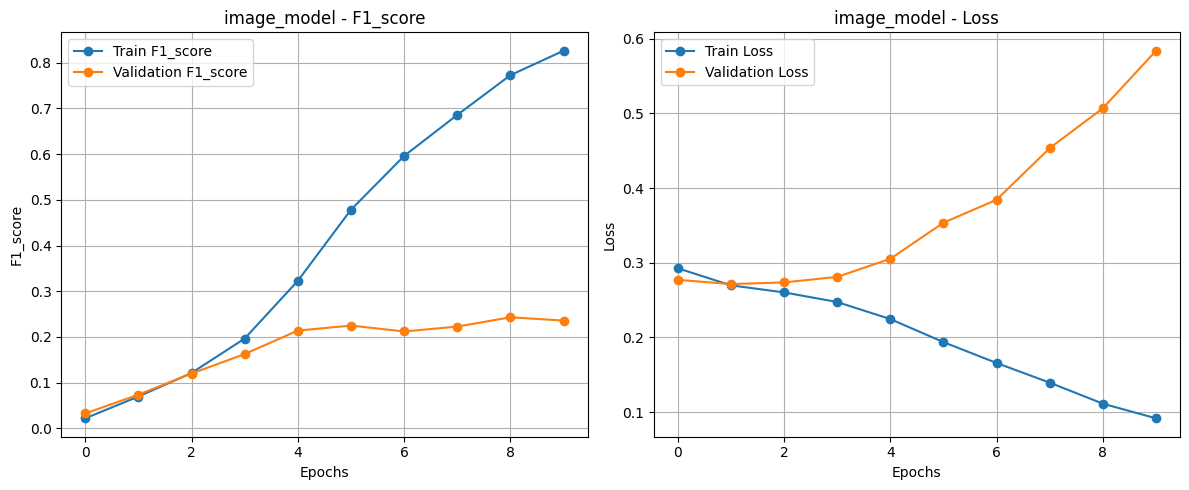

In [18]:
model_performance("image_model", history)

In [19]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(classes_nbr), yticklabels=range(classes_nbr))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

Tester le model sur les données test, afficher la matrice de confusion et interpréter les résultats.

75/75 ━━━━━━━━━━━━━━━━━━━━ 973s 13s/step


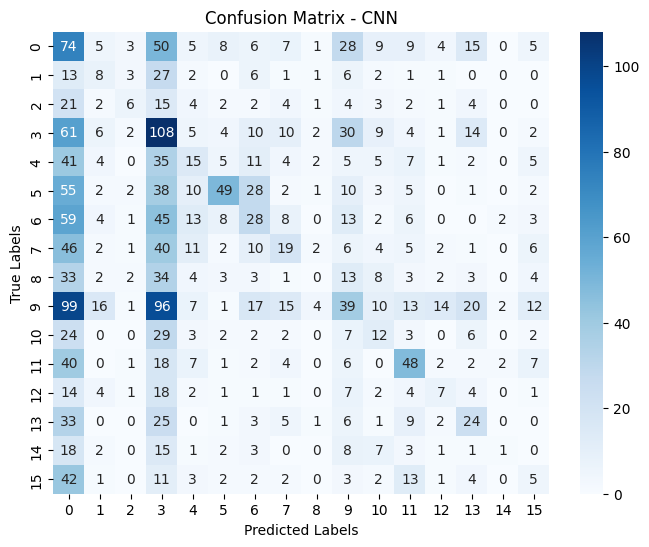

In [20]:
y_pred_cnn = image_model.predict(test_ds)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int) #Convertir les prédictions en labels binaires

plot_confusion_matrix(test_labels, y_pred_cnn, "CNN")

*Le CNN ne prédit pas bien sur la diagonale.*

###Expérimentations avec des architectures CNN avancées
Choisir deux architectures parmi celles vues en cours : VGG, ResNet, Inception, EfficientNet, DenseNet, etc.

*Nous allons utiliser le VGG et le ResNet.*

####VGG

Expérimentation 1 : Transfert d’apprentissage (Feature Extractor) en utilisant un modèle pré-entraîné, ne conserver que l’extracteur de caractéristiques et ajouter une nouvelle tête de classification.

In [21]:
from tensorflow.keras.applications import VGG19

# Charger VGG19 sans la tête de classification (FC layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les poids du modèle pré-entraîné (ne pas entraîner VGG19)
base_model.trainable = False

# Extraction des caractéristiques
x = base_model.output
x = layers.Flatten()(x)  # Aplatir les features extraits

# Nouvelle tête de classification
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
out_image = layers.Dense(classes_nbr, activation="sigmoid")(x)  # Couche de sortie

# Modèle final
vgg1_model = Model(inputs=base_model.input, outputs=out_image)
vgg1_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,254,352 (88.71 MB)

 Trainable params: 3,229,968 (12.32 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [22]:
#Compilation du modèle
vgg1_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_metric])
vgg1_history = vgg1_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 118s 296ms/step - f1_metric: 0.1606 - loss: 0.2964 - val_f1_metric: 0.2610 - val_loss: 0.2554
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 93s 266ms/step - f1_metric: 0.3871 - loss: 0.2097 - val_f1_metric: 0.3143 - val_loss: 0.2509
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 93s 267ms/step - f1_metric: 0.5001 - loss: 0.1822 - val_f1_metric: 0.3615 - val_loss: 0.2530
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 93s 267ms/step - f1_metric: 0.6098 - loss: 0.1547 - val_f1_metric: 0.3816 - val_loss: 0.2700
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 93s 268ms/step - f1_metric: 0.6800 - loss: 0.1339 - val_f1_metric: 0.3328 - val_loss: 0.3490
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 93s 267ms/step - f1_metric: 0.7093 - loss: 0.1249 - val_f1_metric: 0.3655 - val_loss: 0.3204
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 97s 278ms/step - f1_metric: 0.6788 - loss: 0.1341 - val_f1_metric: 0.3941 - val_loss: 0.2947
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 93s 267ms/step - f1_metric: 

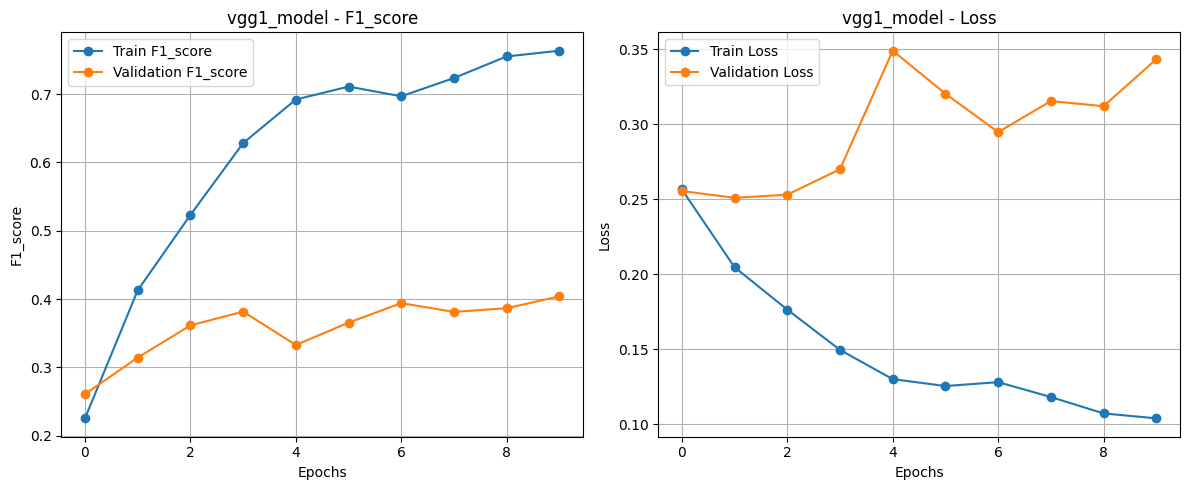

In [23]:
model_performance("vgg1_model", vgg1_history)

75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 314ms/step


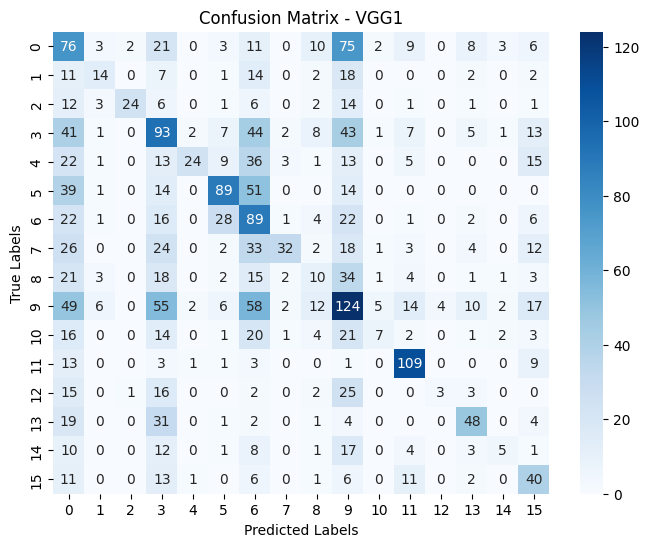

In [24]:
y_pred_vgg1 = vgg1_model.predict(test_ds)
y_pred_vgg1 = (y_pred_vgg1 > 0.5).astype(int) #Convertir les prédictions en labels binaires

plot_confusion_matrix(test_labels, y_pred_vgg1, "VGG1")

*Le VGG19 sans la tête de classification prédit bien sur la diagonale, mais il fait beaucoup d'erreur en dehors de la diagonale.*

Expérimentation 2 : Fine-tuning partiel en dégelant certaines couches et les réentraînant pour adapter le modèle au dataset.

In [25]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler toutes les couches du modèle pré-entraîné
base_model.trainable = False

# Ajout d'une nouvelle tête de classification
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
out_image = layers.Dense(classes_nbr, activation="sigmoid")(x)

# Modèle initial avec uniquement la nouvelle tête entraînable
vgg2_model = Model(inputs=base_model.input, outputs=out_image)

# Compilation et premier entraînement sur la nouvelle tête
vgg2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_metric])
vgg2_model.fit(train_ds, epochs=5, validation_data=val_ds)  #Entraîner d'abord la nouvelle tête

# Fine-Tuning Partiel : dégeler certaines couches du VGG19 (les dernières)
for layer in base_model.layers[-4:]:  #Dégeler uniquement les 4 dernières couches
    layer.trainable = True

Epoch 1/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 97s 273ms/step - f1_metric: 0.1651 - loss: 0.2878 - val_f1_metric: 0.2666 - val_loss: 0.2370
Epoch 2/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 143s 280ms/step - f1_metric: 0.3973 - loss: 0.2080 - val_f1_metric: 0.3135 - val_loss: 0.2336
Epoch 3/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 93s 268ms/step - f1_metric: 0.5210 - loss: 0.1771 - val_f1_metric: 0.3348 - val_loss: 0.2475
Epoch 4/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 93s 267ms/step - f1_metric: 0.6106 - loss: 0.1529 - val_f1_metric: 0.3812 - val_loss: 0.2749
Epoch 5/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 93s 266ms/step - f1_metric: 0.6581 - loss: 0.1399 - val_f1_metric: 0.4008 - val_loss: 0.2980


In [26]:
# Réentraîner le modèle avec un apprentissage plus lent (learning rate réduit)
vgg2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=[f1_metric])
vgg2_history = vgg2_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 115s 313ms/step - f1_metric: 0.7431 - loss: 0.1098 - val_f1_metric: 0.4402 - val_loss: 0.2571
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 105s 301ms/step - f1_metric: 0.8064 - loss: 0.0867 - val_f1_metric: 0.4491 - val_loss: 0.2688
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 105s 302ms/step - f1_metric: 0.8520 - loss: 0.0718 - val_f1_metric: 0.4541 - val_loss: 0.2820
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 105s 302ms/step - f1_metric: 0.8889 - loss: 0.0592 - val_f1_metric: 0.4508 - val_loss: 0.2965
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 106s 305ms/step - f1_metric: 0.9161 - loss: 0.0490 - val_f1_metric: 0.4508 - val_loss: 0.3126
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 106s 304ms/step - f1_metric: 0.9388 - loss: 0.0401 - val_f1_metric: 0.4501 - val_loss: 0.3296
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 105s 302ms/step - f1_metric: 0.9542 - loss: 0.0326 - val_f1_metric: 0.4520 - val_loss: 0.3483
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 105s 303ms/step - f1_m

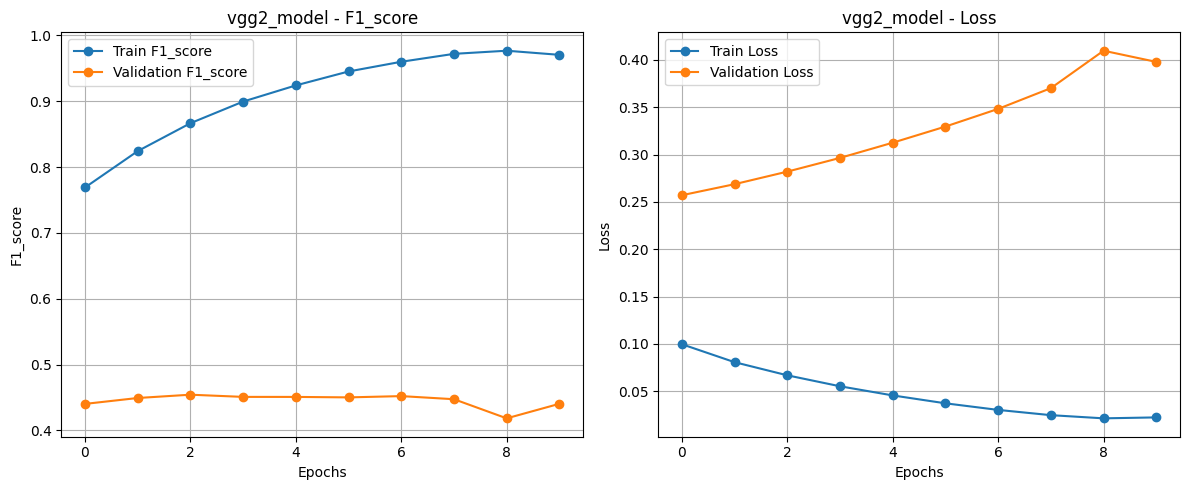

In [27]:
model_performance("vgg2_model", vgg2_history)

*Pendant l'entrainnement, le modèle vgg2 à un score qui est proche de 1 et l'erreur est très proche de 0 alors le score f1 et l'erreur sont proche de 0,5. On voit sur la matrice de confusion qu'il prédit bien les valeurs sur la diagonale, bien qu'il fait des erreurs*

75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step


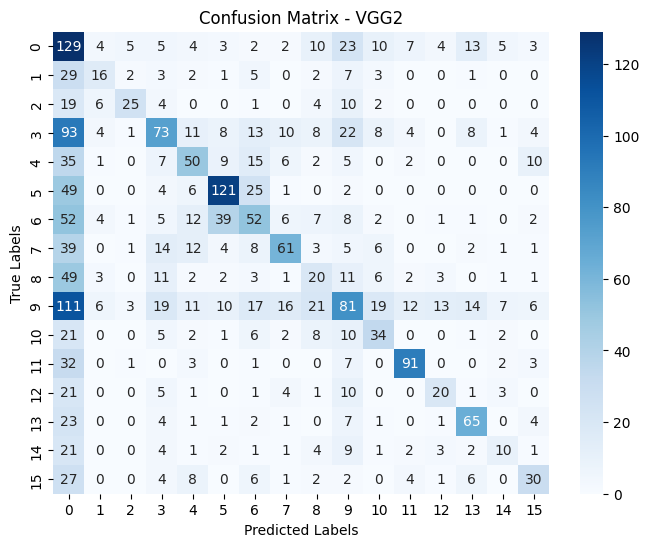

In [28]:
y_pred_vgg2 = vgg2_model.predict(test_ds)
y_pred_vgg2 = (y_pred_vgg2 > 0.5).astype(int) #Convertir les prédictions en labels binaires

plot_confusion_matrix(test_labels, y_pred_vgg2, "VGG2")

Expérimentation 3 : Entraînement « from scratch » sans poids pré-entraînés.

In [29]:
base_model = VGG19(weights=None, include_top=False, input_shape=(224, 224, 3))

# Ajouter une nouvelle tête de classification
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
out_image = layers.Dense(classes_nbr, activation="sigmoid")(x)

# Créer le modèle final
vgg3_model = Model(inputs=base_model.input, outputs=out_image)

In [32]:
# Compilation avec un **learning rate plus élevé** pour partir de zéro
vgg3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=[f1_metric])

# Entraînement du modèle
vgg3_history = vgg3_model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 228s 604ms/step - f1_metric: 0.0000e+00 - loss: 0.2966 - val_f1_metric: 0.0000e+00 - val_loss: 0.2964
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 205s 589ms/step - f1_metric: 0.0000e+00 - loss: 0.2955 - val_f1_metric: 0.0000e+00 - val_loss: 0.2963
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 205s 589ms/step - f1_metric: 0.0000e+00 - loss: 0.2952 - val_f1_metric: 0.0000e+00 - val_loss: 0.2964
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 210s 604ms/step - f1_metric: 0.0000e+00 - loss: 0.2950 - val_f1_metric: 0.0000e+00 - val_loss: 0.2964
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 204s 587ms/step - f1_metric: 0.0000e+00 - loss: 0.2949 - val_f1_metric: 0.0000e+00 - val_loss: 0.2963
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 262s 589ms/step - f1_metric: 0.0000e+00 - loss: 0.2949 - val_f1_metric: 0.0000e+00 - val_loss: 0.2963
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 204s 587ms/step - f1_metric: 0.0000e+00 - loss: 0.2948 - val_f1_metric: 0.0000e+00 - val_loss: 0.2962
Epoch 

*Le VGG from scratch n'arrive pas à s'entraîner sur nos données.*

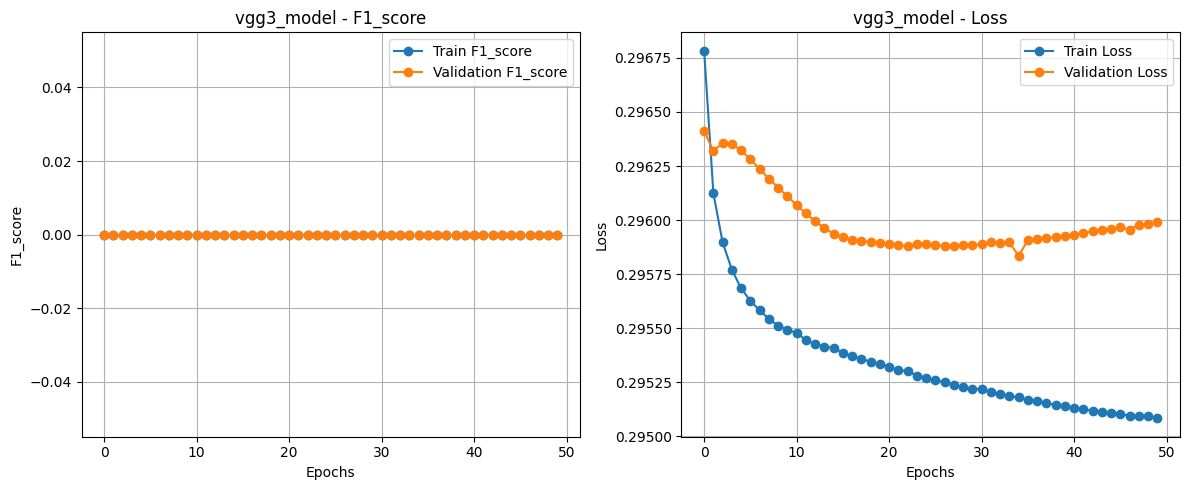

In [33]:
model_performance("vgg3_model", vgg3_history)

75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 219ms/step


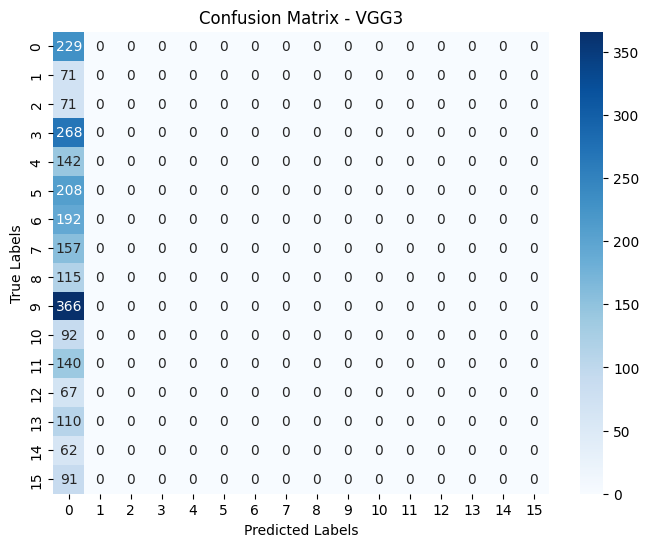

In [34]:
y_pred_vgg3 = vgg3_model.predict(test_ds)
y_pred_vgg3 = (y_pred_vgg3 > 0.5).astype(int) #Convertir les prédictions en labels binaires

plot_confusion_matrix(test_labels, y_pred_vgg3, "VGG3")

####ResNet

Expérimentation 1 : Transfert d’apprentissage (Feature Extractor) en utilisant un modèle pré-entraîné, ne conserver que l’extracteur de caractéristiques et ajouter une nouvelle tête de classification.

In [35]:
from tensorflow.keras.applications import ResNet50

# Charger ResNet50 pré-entraîné sur ImageNet, sans la tête FC
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler toutes les couches
base_model.trainable = False

# Ajout d'une nouvelle tête de classification
x = layers.GlobalAveragePooling2D()(base_model.output)  # Remplace Flatten pour réduire les paramètres
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
out_image = layers.Dense(classes_nbr, activation="sigmoid")(x)

# Modèle final
resnet1_model = Model(inputs=base_model.input, outputs=out_image)
resnet1_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,859,280 (91.02 MB)

 Trainable params: 271,568 (1.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [36]:
resnet1_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_metric])

# Entraînement
resnet1_history = resnet1_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 171ms/step - f1_metric: 0.0072 - loss: 0.3113 - val_f1_metric: 0.0000e+00 - val_loss: 0.2915
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 48s 139ms/step - f1_metric: 0.0032 - loss: 0.2887 - val_f1_metric: 0.0000e+00 - val_loss: 0.2857
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 49s 142ms/step - f1_metric: 0.0060 - loss: 0.2835 - val_f1_metric: 5.2288e-04 - val_loss: 0.2807
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 80s 137ms/step - f1_metric: 0.0087 - loss: 0.2794 - val_f1_metric: 0.0050 - val_loss: 0.2772
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 46s 133ms/step - f1_metric: 0.0106 - loss: 0.2767 - val_f1_metric: 0.0060 - val_loss: 0.2758
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - f1_metric: 0.0097 - loss: 0.2749 - val_f1_metric: 0.0070 - val_loss: 0.2738
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - f1_metric: 0.0123 - loss: 0.2731 - val_f1_metric: 0.0081 - val_loss: 0.2726
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 48s 139ms/step - 

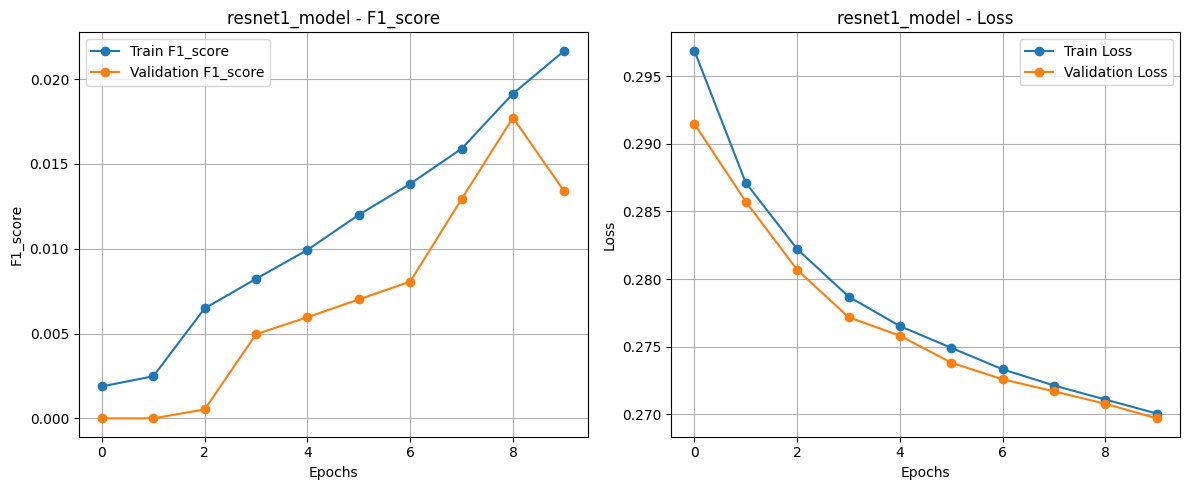

In [37]:
model_performance("resnet1_model", resnet1_history)

75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step


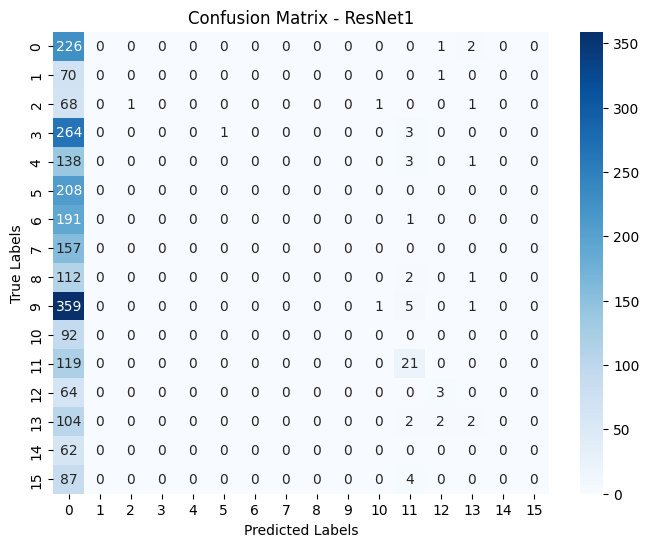

In [38]:
y_pred_resnet1 = resnet1_model.predict(test_ds)
y_pred_resnet1 = (y_pred_resnet1 > 0.5).astype(int) #Convertir les prédictions en labels binaires

plot_confusion_matrix(test_labels, y_pred_resnet1, "ResNet1")

*On a pas de bonne courbe d'apprentissage, et la matrice de confusion montre que le modèle ResNet fine-tuné prédit pas de classe vrai à part la classe 2 sur l'index 0.*

Expérimentation 2 : Fine-tuning partiel en dégelant certaines couches et les réentraînant pour adapter le modèle au dataset.

In [53]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler toutes les couches au départ
base_model.trainable = False

# Ajout d'une nouvelle tête de classification
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
out_image = layers.Dense(classes_nbr, activation="sigmoid")(x)

# Création et entraînement du modèle (uniquement la nouvelle tête)
resnet2_model = Model(inputs=base_model.input, outputs=out_image)
resnet2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_metric])
resnet2_model.fit(train_ds, epochs=5, validation_data=val_ds)

for layer in base_model.layers[-10:]:  # On dégèle les 10 dernières couches
    layer.trainable = True

# Réentraîner avec un learning rate réduit
resnet2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    loss='binary_crossentropy', metrics=[f1_metric])
resnet2_history = resnet2_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 68s 166ms/step - f1_metric: 0.0150 - loss: 0.3242 - val_f1_metric: 0.0000e+00 - val_loss: 0.2922
Epoch 2/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - f1_metric: 4.4599e-04 - loss: 0.2885 - val_f1_metric: 5.1282e-04 - val_loss: 0.2857
Epoch 3/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 60s 173ms/step - f1_metric: 0.0028 - loss: 0.2832 - val_f1_metric: 5.0314e-04 - val_loss: 0.2811
Epoch 4/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 45s 129ms/step - f1_metric: 0.0063 - loss: 0.2797 - val_f1_metric: 0.0017 - val_loss: 0.2791
Epoch 5/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 48s 139ms/step - f1_metric: 0.0072 - loss: 0.2775 - val_f1_metric: 0.0060 - val_loss: 0.2771
Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 71s 159ms/step - f1_metric: 0.0109 - loss: 0.3031 - val_f1_metric: 0.0624 - val_loss: 0.2856
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - f1_metric: 0.0142 - loss: 0.2676 - val_f1_metric: 0.0406 - val_loss: 0.2702
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 49s 142ms/step - f

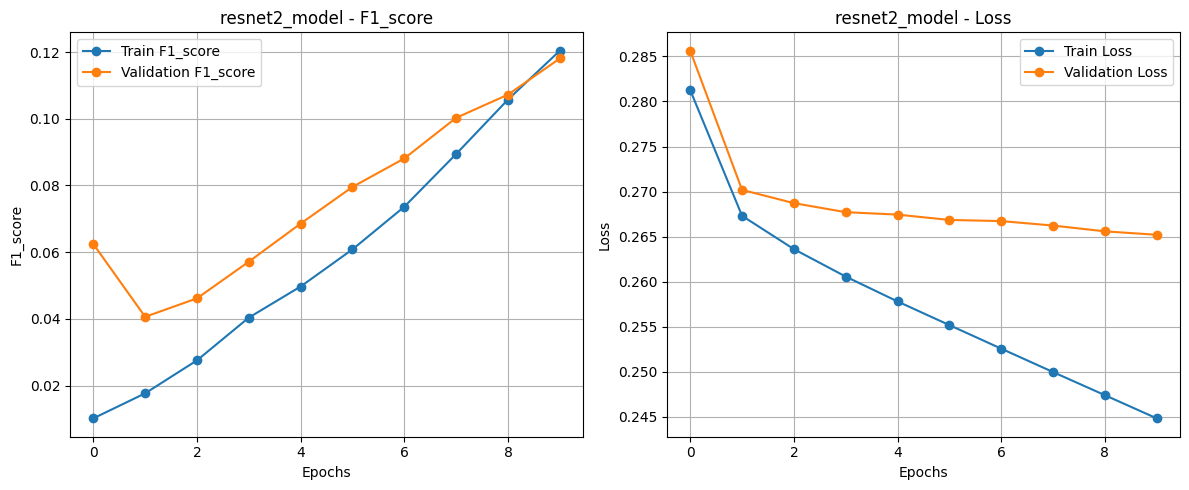

In [54]:
model_performance("resnet2_model", resnet2_history)

75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step


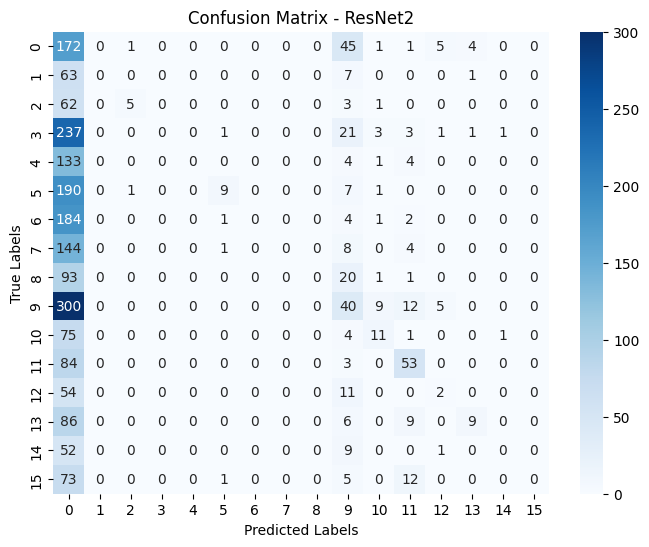

In [55]:
y_pred_resnet2 = resnet2_model.predict(test_ds)
y_pred_resnet2 = (y_pred_resnet2 > 0.5).astype(int) #Convertir les prédictions en labels binaires

plot_confusion_matrix(test_labels, y_pred_resnet2, "ResNet2")

In [44]:
# Charger ResNet50 SANS poids pré-entraînés
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Ajout d'une nouvelle tête de classification
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
out_image = layers.Dense(classes_nbr, activation="sigmoid")(x)

# Modèle final
resnet3_model = Model(inputs=base_model.input, outputs=out_image)

# Compilation avec un learning rate plus élevé (on part de zéro)
resnet3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss='binary_crossentropy', metrics=[f1_metric])

# Entraînement (besoin de plus d’époques)
resnet3_history = resnet3_model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 197s 402ms/step - f1_metric: 0.0183 - loss: 0.3191 - val_f1_metric: 0.1873 - val_loss: 3.8278
Epoch 2/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 116s 332ms/step - f1_metric: 0.0123 - loss: 0.2816 - val_f1_metric: 0.0000e+00 - val_loss: 1.1299
Epoch 3/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 112s 320ms/step - f1_metric: 0.0096 - loss: 0.2811 - val_f1_metric: 0.0565 - val_loss: 0.2808
Epoch 4/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 113s 324ms/step - f1_metric: 0.0269 - loss: 0.2720 - val_f1_metric: 5.5556e-04 - val_loss: 0.8431
Epoch 5/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 115s 329ms/step - f1_metric: 0.0586 - loss: 0.2677 - val_f1_metric: 0.0269 - val_loss: 0.3170
Epoch 6/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 115s 330ms/step - f1_metric: 0.0638 - loss: 0.2661 - val_f1_metric: 0.0270 - val_loss: 0.2940
Epoch 7/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 115s 329ms/step - f1_metric: 0.0809 - loss: 0.2630 - val_f1_metric: 0.0139 - val_loss: 0.3521
Epoch 8/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 115s 329ms/ste

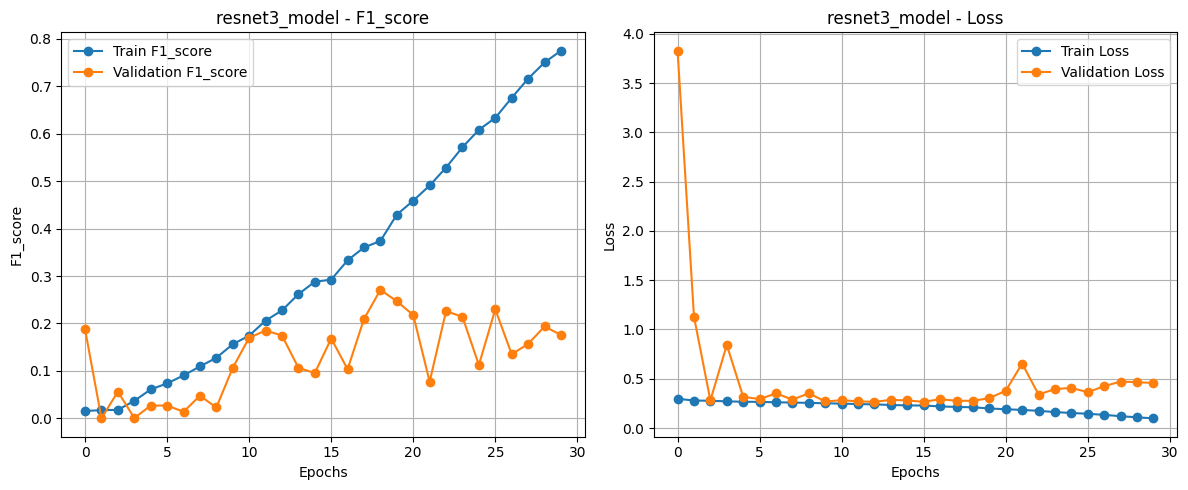

In [45]:
model_performance("resnet3_model", resnet3_history)

75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step


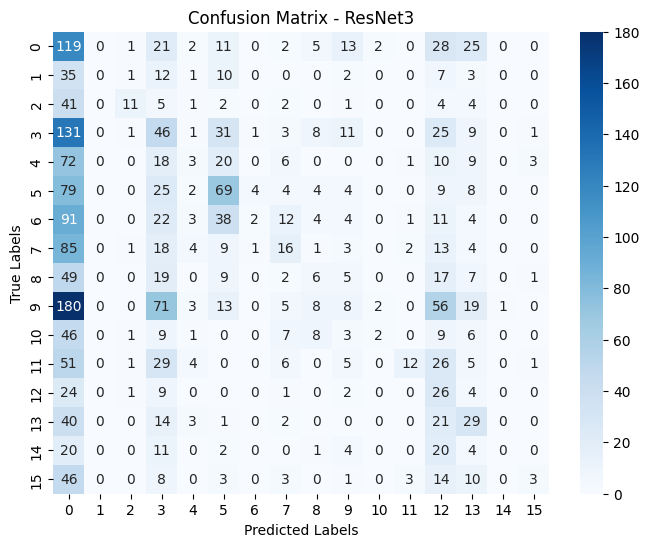

In [46]:
y_pred_resnet3 = resnet3_model.predict(test_ds)
y_pred_resnet3 = (y_pred_resnet3 > 0.5).astype(int) #Convertir les prédictions en labels binaires

plot_confusion_matrix(test_labels, y_pred_resnet3, "ResNet3")

*Le resnet3 prédit pas bien sur la diagonale.*

####Comparaison des résultats et choix du modèle final.


Comparer les performances des différents modèles expérimentés à l’aide de la matrice de confusion et des métriques sélectionnées, adaptées à la classification multi-label.

Tous les modèles prédisent bien les vrais négatifs.
- le vgg3, les expérimentations sur le ResNet n'arrive pas à predire les vrais positifs (diagonale de la matrice de confusion).
- le vgg1, le vgg2 et le cnn arrivent à predire les vrais positifs et ont de bonne courbe d'apprentissage avec des erreurs en dehors de la diagonale.

Justifier le choix du modèle retenu.

*Nous avons retenu le vgg2, car il a de meilleurs courbes d'apprentissage qur les autres modèles et il presente un meilleur diagonale (prédiction des vrais positifs) que les autres.*

####Analyse des résultats


Afficher quelques images de test avec les prédictions et les scores de confiance correspondants.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
True:['3']
Pred:['18']
Pred: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
True:['10' '2' '3']
Pred:['3']
Pred: [0.  0.  0.1 0.1 0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.1 0. ]
True: [1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
True:['8' '9']
Pred:['3' '9']
Pred: [0.  0.  0.  0.2 0.  0.  0.1 0.  0.  0.4 0.  0.  0.  0.  0.  0.7]
True: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
True:['17']
Pred:['17' '18']
Pred: [0.  0.  0.  0.  0.  0.9 1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
True: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True:['17']
Pred:['17']
Pred: [0.  0.  0.  0.  0.  0.6 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
True: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True:['7']
Pred:['7']
Pred: [0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  1.  0.  0. ]
True: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
True:['19' '3']
Pred:[]
Pred: [0.  0.  0.  0.1 0. 

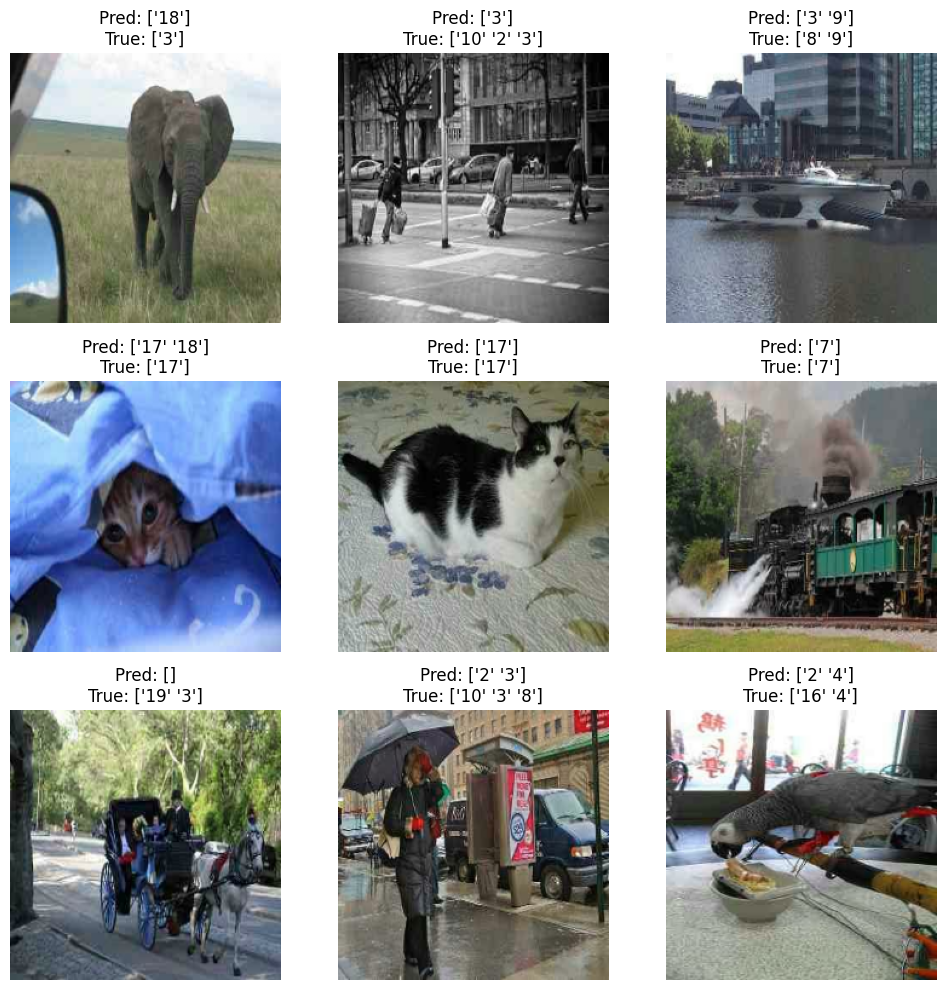

In [47]:
# Visualize a few predictions from the image model
batch = next(iter(test_ds))

images_batch,labels_batch = batch # Change this line to unpack only 2 values
preds_img = vgg2_model.predict(images_batch)
plt.figure(figsize=(10, 10))

for i in range(min(9, images_batch.shape[0])):
    true_labels = mlb.classes_[labels_batch[i] == 1]
    print(f"True:{true_labels}")
    predicted_labels = mlb.classes_[preds_img[i] > 0.4]
    print(f"Pred:{predicted_labels}")
    print(f"Pred: {np.around(preds_img[i], 1)}\nTrue: {labels_batch[i]}")
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_batch[i])
    plt.title(f"Pred: {predicted_labels}\nTrue: {true_labels}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Utiliser des techniques d’interprétation, comme LIME, pour mieux comprendre les décisions du modèle.

In [50]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=02f8805f5a66a17102b0cea1904e7b5ab76c6a51536a54fa57d6a7408ab02233
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [51]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

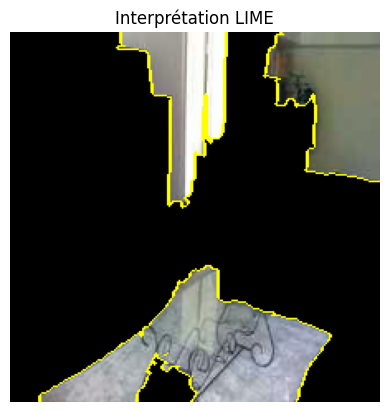

In [52]:
# Créer l'explainer pour les images
explainer = lime_image.LimeImageExplainer()

# Sélectionner une image de test
test_image, test_label = next(iter(val_ds))  # Une image du dataset de validation
test_image = test_image[0].numpy()

# Fonction de prédiction adaptée à LIME
def predict_fn(images):
    images = np.array(images)
    return vgg2_model.predict(images)

# Explication de l'image avec LIME
explanation = explainer.explain_instance(
    test_image, predict_fn, top_labels=1, hide_color=0, num_samples=1000
)

# Visualisation des superpixels les plus importants
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=True
)

# Affichage de l'image avec l'explication LIME
plt.imshow(mark_boundaries(temp, mask))
plt.title("Interprétation LIME")
plt.axis("off")
plt.show()

*Ces régions (bordures jaunes) sont les plus importantes pour la décision du modèle.*

Examiner des erreurs de prédiction et essayer d’identifier des explications.

- Mauvaises prédictions : Plusieurs exemples montrent des classes incorrectement prédites (ex: True: ['3'] → Pred: ['18']).

- Faux positifs : Certaines classes sont prédites alors qu'elles ne devraient pas l’être (Pred: ['17', '18'] alors que le vrai label est ['17']).

- Faux négatifs : Certaines classes attendues ne sont pas prédites (True: ['19', '3'] → Pred: []).

*Célà arrive peut être parceque les données d'entraînement déséquilibrées.*

 Interpréter les résultats et proposer des pistes d’amélioration.

*Augmenter (oversampling) les données des classes sous-représentées (data augmentation).*